### Блок теоретических вопросов

*Отличие градиентного бустинга от обычного бустинга заключается в следующем*: 

1.	Градиентный бустинг обучается с помощью градиентного спуска (возможно стохастического), тогда как обычный бустинг последовательно обучается на отклонениях предыдущей базовой модели от истинных ответов.
2.	Градиентный бустинг – это более общий случай бустинга, который имплементирует подсчет антиградиентов внутри самого функционала, позволяя ускорить обучение.
3.	Градиентный бустинг обобщает подход обычного бустинга на функционалы любого вида, путем подсчета их градиента на N-ом шаге в точке базовой модели на N-1 шаге.
4.	Обычный бустинг – это частный случай градиентного с функционалом MSE, так как антиградиент MSE в точке композиции на N-1 шаге это и есть остатки предыдущей композиции. 






**Ответ: 4)** В действительности, градиентный бустинг в некотором смысле обобщает обычный бустинг. Тем не менее, указанные различия в 1-3 пунктах недостаточно освещены. 

___________________________________________

*Допустим, предсказания первой базовой модели равны (-1, 2, 10), а истинные значения целевой переменной (0, 5, 3) соответственно. Как будет выглядеть функция потерь для второй базовой модели, если мы минимизируем функционал RMSE (корень из MSE)?*: 

1.	Сумма квадратов отклонения базовой модели от антиградиента RMSE в точке (-1, 2, 10). 
2.	RMSE между истинными метками (0, 5, 3) и остатками предыдущей композиции, то есть разницы целевой переменной и предсказаниями первой базовой модели
3.	Корень из суммы квадратов отклонения базовой модели от антиградиента RMSE в точке (0, 5, 3).
4.	MSE между прогнозом первой базовой модели (-1, 2, 10) и остатками предыдущей композиции, то есть разницы целевой переменной и предсказаниями первой базовой модели.







**Ответ: 1)** По сути, градиентный бустинг первого порядка поступает следующим образом после построения первой модели: вычисляет значение антиградиента в текущей точке в пространстве предсказания, то есть отступы $s^{(1)}$, а после обучает вторую модель по квадратичному функционалу:

$$
\sum (b_2(x_i) - s_i^{(1)})^2 \rightarrow min
$$
___________________________________________

*Как выглядят кривые ошибок при росте числа деревьев для бустинга на тестовой и обучающей выборках?*: 

1.	На обучающей выборке ошибка сначала падает, а затем растет из-за переобучения, тогда как на тестовой выборке постоянно падает, так как бустинг уменьшает смещение композиции.
2.	На обучающей выборке ошибка всегда падает, так как бустинг может восстановить любую зависимость, тогда как на тесте ошибка растет из-за переобучения. 
3.	На тестовой выборке ошибка сначала падает, а затем растет, так как модель начинает подстраиваться под обучающую выборку, на которой ошибка только падает. 
4.	 На тестовой выборке ошибка сначала растет, а затем падает, так как обобщающая способность модели начинает расти, в силу свойства бустинга снижать смещение, в то время как на обучающей выборке ошибка падает.




**Ответ: 3)** 
___________________________________________

*В чем отличие бустинга от других методов ансамблирования с точки зрения смещения и разброса?*: 

1.	Случайный лес, в отличие от бустинга снижает смещение базовых моделей, путем поиска лучшего предиката на случайном подмножестве признаков, в то время как бустинг позволяет снизить только разброс, если выбрана простая базовая модель.
2.	Бустинг глубоких деревьев обладает большим разбросом из-за своей сложности, в то время как бэггинг глубоких деревьев позволяет снизить смещение базовых деревьев путем усреднения их предсказаний. 
3.	Бэггинг неглубоких деревьев позволяет снизить большое смещение базовых моделей, в то время как бустинг на неглубоких деревьях оптимальный вариант бустинга, так как он не может уменьшить разброс базовых моделей.
4.	Бустинг позволяет снижать смещение с каждой новой итерацией, так как он обучается на остатках, в то время как бэггинг независимых деревьев снижает разброс, не затрагивая при этом смещение базовой модели.





**Ответ: 4)** Обсуждали на лекции. Строгое математическое доказательство приводить не станем.
___________________________________________

### Блок практики

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib
matplotlib.rcParams['figure.figsize'] = (8, 5)

import warnings
warnings.filterwarnings('ignore')
import time

# Boostings

Данные с которыми вы будете работать представляют из себя характеристики клиента страховой компании по которым нужно понять будет ли он заинтересован в страховке. Таким образом, страховая компания может более оптимально таргетить рекламу и выстраивать коммуникацию с клиентами, повышая конверсию.

**Описания колонок:**
- Gender - Male, Female
- Age - Возраст
- Driving_License - Наличие водительского удостоверения
- Region_Code - Область проживания
- Previously_Insured - Пользовался ли раньше услугами страховой компании
- Vehicle_Age - Возраст транспортного средства
- Vehicle_Damage - Попадало ли траспортное средство в ДТП
- Annual_Premium - Ежегодные вылаты клиента
- Policy_Sales_Channel - Политика распространения страховых услуг (через посредников, напрямую и т.д.)
- Vintage - Количество дней, в течение которых rлиент был связан с компанией 


- **Response** - заинтересован в страховке 1, не откликнулся 0

In [2]:
### Загрузим данные

data = pd.read_csv('vehicle_insurance.csv')

data

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0
...,...,...,...,...,...,...,...,...,...,...,...
9995,Female,24,1,37.0,1,< 1 Year,No,21243.0,152.0,21,0
9996,Male,28,1,35.0,1,< 1 Year,No,23589.0,160.0,173,0
9997,Female,27,1,15.0,0,< 1 Year,Yes,33340.0,152.0,207,0
9998,Female,28,1,14.0,1,< 1 Year,No,25426.0,152.0,247,0


**Задание 0.** Проведите небольшой EDA. Посмотрите на распределения некоторых колонок, на матрицу корреляций. Также проверьте баланс классов и посмотрите на распределение возраста транспортного средства в зависимости от response. \
Закодируйте признаки типа `object` с помощью `one-hot` кодирования.

P.S. некоторые не `object`колонки по смыслу очевидно являются категориальными. Так как мы будем строить ансамбли на основе деревьев, их можно оставить в первоначальном виде.

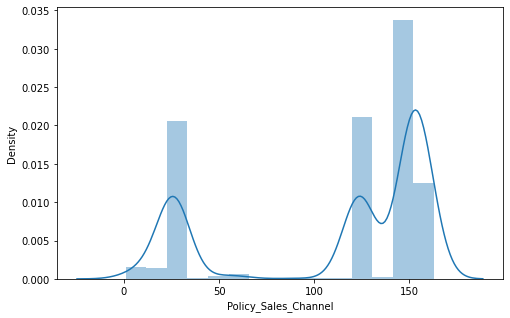

In [3]:
sns.distplot(data['Policy_Sales_Channel']);

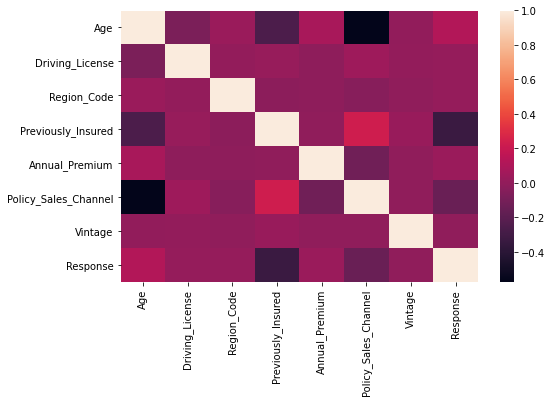

In [4]:
sns.heatmap(data.corr());

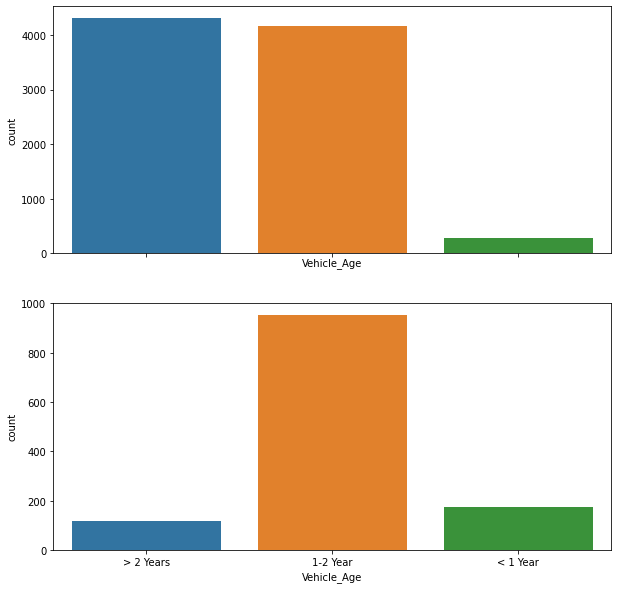

In [5]:
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(10, 10))

sns.countplot(data = data[data['Response'] == 0], x = 'Vehicle_Age', ax=axes[0])
sns.countplot(data = data[data['Response'] == 1], x = 'Vehicle_Age', ax=axes[1]);

In [6]:
data['Response'].value_counts(True)

0    0.8753
1    0.1247
Name: Response, dtype: float64

In [3]:
### сохраним текущую форму датасета

data_copy = data.copy()

In [4]:
### Проведем Mean Target Encoding

data = pd.get_dummies(data, drop_first=True)
data.head()

,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage,Response,Gender_Male,Vehicle_Age_< 1 Year,Vehicle_Age_> 2 Years,Vehicle_Damage_Yes
0,44,1,28.0,0,40454.0,26.0,217,1,True,False,True,True
1,76,1,3.0,0,33536.0,26.0,183,0,True,False,False,False
2,47,1,28.0,0,38294.0,26.0,27,1,True,False,True,True
3,21,1,11.0,1,28619.0,152.0,203,0,True,True,False,False
4,29,1,41.0,1,27496.0,152.0,39,0,False,True,False,False


**Задание 1.** Обучите градиентный бустинг из sklearn на данных и замерьте accuracy и f1-score на тестовой выборке. В качестве параметров ансамбля установите `learning_rate = 1`, `random_state = 1`, `n_estimators = 100`. Изобразите ROC-кривую и посчитайте AUC, оцените качество классификации. (2б)

P.S. для всех прочих моделей в этом домашнем задании тоже фиксируйте `random_state = 1`. Как думаете, что может быть случайного в процедуре обучения градиентного бустинга?

In [5]:
### Разобьем выборку на трейн и тест

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score, roc_curve, auc

X = data.drop('Response', axis=1)
y = data['Response']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=0,
                                                    shuffle=True,
                                                    test_size=0.2)

In [6]:
### Обучим градиентный бустинг из sklearn

from sklearn.ensemble import GradientBoostingClassifier

model = GradientBoostingClassifier(learning_rate=1,
                                   n_estimators=100,
                                   random_state=1)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.93      0.92      1770
           1       0.31      0.24      0.27       230

    accuracy                           0.85      2000
   macro avg       0.61      0.59      0.59      2000
weighted avg       0.84      0.85      0.84      2000



Area under curve (AUC):  0.8282399901744043


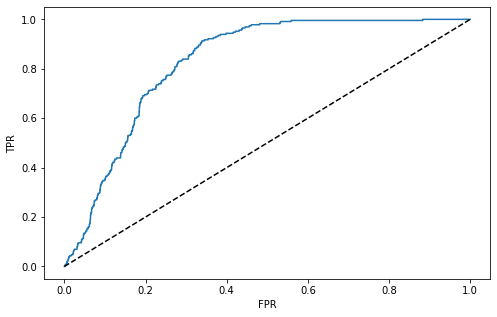

In [11]:
### Построим рок-кривую и замерим площадь под ней

y_score = model.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, y_score)

plt.xlabel('FPR')
plt.ylabel('TPR')

plt.plot(fpr,tpr)
plt.plot((0,1), ls='dashed',color='black');
print ('Area under curve (AUC): ', auc(fpr, tpr))

**Задание 2.** Переберите параметры `n_estimators` и `learning_rate` по двумерной сетке. При обучении в цикле сразу считайте f1-score на тестовой выборке и сохраняйте результат в матрицу. Для какого алгоритма качество окажется максимальным?

Постройте кривые для метрики f1-score в зависимости от числа шагов для нескольких learning_rate. Изобразите heatmap полученной матрицы. Сделайте вывод, как количество шагов влияет на качество совместно с различной скоростью обучения? (2б)

P.S. для подсчета f1-score передайте в функцию параметр `average='weighted'`, чтобы учитывался еще и баланс классов (вспомните микро/макро-усреднения).

In [12]:
# Задаем сетку параметров
n_estimators_list = [5, 10, 20, 50, 100, 200, 700, 1000]
learning_rate_list = [1, 0.1, 0.01]

f1_matrix = np.zeros((len(n_estimators_list), len(learning_rate_list)))

for (i, n) in enumerate(n_estimators_list):
    for (j, lr) in enumerate(learning_rate_list):
        model = GradientBoostingClassifier(n_estimators=n,
                                           learning_rate=lr,
                                           max_depth=5,
                                           random_state=1)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        # Суём в матрицу
        f1_matrix[i, j] = f1_score(y_test, y_pred, average='weighted')
        
print(f1_matrix)

f1_dataframe = pd.DataFrame(f1_matrix, 
                            index=map(str, n_estimators_list), 
                            columns=map(str, learning_rate_list))

[[0.83598325 0.83197068 0.83100796]
 [0.83840034 0.83197068 0.83100796]
 [0.84418229 0.83171715 0.83100796]
 [0.83603288 0.83162689 0.83222411]
 [0.83748981 0.83772792 0.83197068]
 [0.842608   0.84312432 0.83171715]
 [0.84401864 0.84268016 0.8348982 ]
 [0.84644748 0.8460635  0.83711097]]


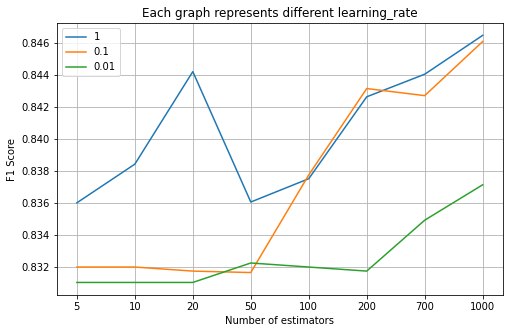

In [13]:
### Строим обучающие кривые

plt.plot(f1_dataframe)

plt.title('Each graph represents different learning_rate')
plt.xlabel('Number of estimators')
plt.ylabel('F1 Score')

plt.grid()
plt.legend(learning_rate_list);

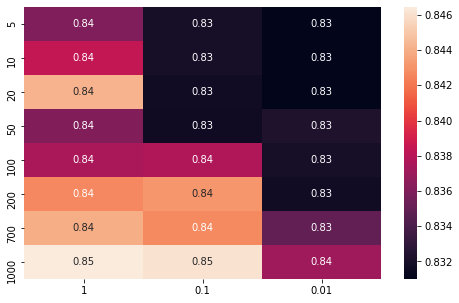

In [14]:
### Построим карту с качеством для наборов параметров

sns.heatmap(f1_dataframe, annot=True);

In [15]:
model = GradientBoostingClassifier(learning_rate=1,
                                   n_estimators=1000,
                                   random_state=1)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.9049    0.9249    0.9148      1770
           1     0.3037    0.2522    0.2755       230

    accuracy                         0.8475      2000
   macro avg     0.6043    0.5885    0.5952      2000
weighted avg     0.8358    0.8475    0.8413      2000



**Задание 3.** Вам потребуется обучить 4 модели и посчитать метрику f1-score на тестовой и обучающей выборках для каждой модели. 
1. Случайный лес с максимальной глубиной деревьев 5,
2. Случайный лес с максимальной глубиной деревьев 5000,
3. Градиентный бустинг с максимальной глубиной деревьев 5,
4. Градиентный бустинг с максимальной глубиной деревьев 5000.

Для каждой модели перебирайте значения `n_estimators`, как в предыдущем задании. Отрисуйте графики зависимости f1-score от количества шагов. 

Если в качестве базовой модели брать неглубокие деревья, то какая модель лучше запоминает обучающую выборку: случайный лес или градиентный бустинг? Какая из них лучше предсказывает на тестовой выборке? Как изменятся ответы, если базовая модель - это глубокое решающее дерево?

-- Для случайного леса берем глубокие деревья, так как это модели с низким смещением. Для градиентного бустинга - неглубокие, так как требуем низкий разброс

Подвержен ли переобучению случайный лес и градиентный бустинг? Как это отражается на графиках? (4б)

-- Случайный лес - нет, градиентный бустинг - вполне

In [16]:
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

In [17]:
### Обучим на заданных параметрах различные модели

n_estimators_list = [2, 3, 4, 5, 10, 20, 50, 70, 100, 200, 700, 1000, 2000]
f1_matrix = np.zeros((len(n_estimators_list), 8))

for (j, max_depth) in enumerate([5, 5000]):
    for (i, n) in enumerate(n_estimators_list):

        rf = RandomForestClassifier(n_estimators=n,
                                    max_depth=max_depth,
                                    random_state=1)
        rf.fit(X_train, y_train)
        rf_pred_test, rf_pred_train = rf.predict(X_test), rf.predict(X_train)

        lgb = GradientBoostingClassifier(n_estimators=n,
                                         max_depth=max_depth,
                                         random_state=1)
        lgb.fit(X_train, y_train)
        lgb_pred_test, lgb_pred_train = lgb.predict(X_test), lgb.predict(X_train)
        
        f1_matrix[i, j*4:j*4+4] = (f1_score(y_test, rf_pred_test, average='weighted'),
                                   f1_score(y_train, rf_pred_train, average='weighted'),
                                   f1_score(y_test, lgb_pred_test, average='weighted'),
                                   f1_score(y_train, lgb_pred_train, average='weighted'))
        
trees = list(map(str, n_estimators_list))

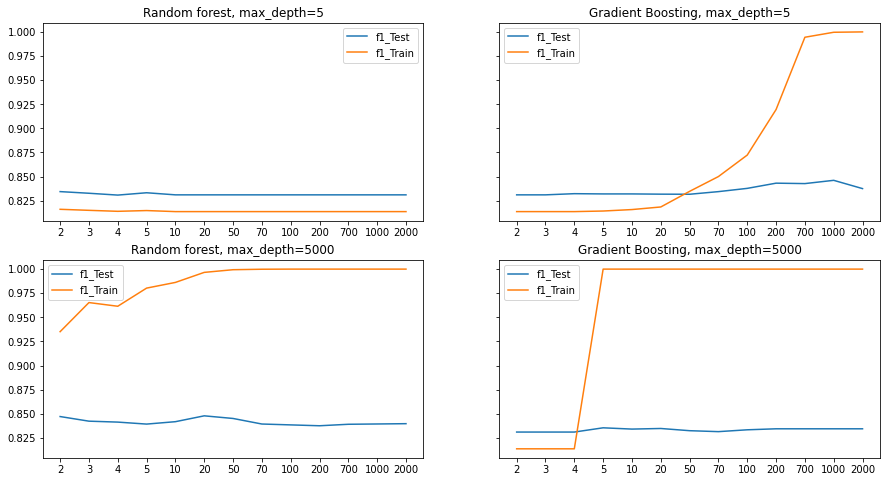

In [18]:
### Нарисуем обучающие кривые

fig, axs = plt.subplots(2, 2, figsize = (15, 8), sharey=True)

for (i, ax) in enumerate(axs.reshape(-1)):
    ax.plot(trees, f1_matrix[:, i*2], label = 'f1_Test')
    ax.plot(trees, f1_matrix[:, i*2+1], label = 'f1_Train')
    ax.legend()
    
axs[0, 0].set_title('Random forest, max_depth=5')
axs[1, 0].set_title('Random forest, max_depth=5000')

axs[0, 1].set_title('Gradient Boosting, max_depth=5')
axs[1, 1].set_title('Gradient Boosting, max_depth=5000');

**Задание 4.** Установите библиотеку `catboost`. Главной особенностью catboost явялется наличие встроенной обработки категориальных признаков. Для каждого категориального столбца вычисляется следующее значение
$$
avg\_target = \dfrac{countInClass + prior}{totalCount + 1},
$$
* countInClass - количество объектов положительного класса для данной категории **до текущего объекта**,
* prior - некоторая константа для числителя, обычно равна доле положительного класса в таргете,
* totalCount - количество наблюдаемых категорий вплоть **до текущего** с той же категорией, что и у текущего.

Так как первые такие значения будут иметь больший разброс, чем последние, то выборку перемешивают несколько раз и полученные статистики усредняют. 
В отличие от target encoder подсчитанные значения зависят от наблюдаемой истории, т.е. вычисляются только из наблюдений до них, таким образом не происходит target leakage. 

Почитать подробнее можно здесь: [Transforming categorical features](https://catboost.ai/en/docs/concepts/algorithm-main-stages_cat-to-numberic)

Обучите CatBoostClassifier с дефолтными параметрами. Используйте датасет до  (разбейте на train/test по старой логике с тем же random state'ом). Категориальные колонки передайте в параметр `cat_features` метода `fit`. Catboost сам с ними разберется.

Сравните качество с моделью из предыдущего задания. Стало ли лучше?

Сравните feature importances в модели из задания 2 и в catboost с помощью соответствующих методов, изобразите их, используя `barplot`. \
Какие признаки стали более важными с новым методом кодирования? (4б)

In [19]:
from catboost import CatBoostClassifier

X = data_copy.drop('Response', axis=1)
y = data_copy['Response']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=0,
                                                    shuffle=True,
                                                    test_size=0.2)

cboost = CatBoostClassifier(verbose=0)

cboost.fit(X_train,
           y_train,
           cat_features=['Gender', 'Vehicle_Age', 'Vehicle_Damage'])

y_pred = cboost.predict(X_test)

print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.8891    0.9870    0.9355      1770
           1     0.3429    0.0522    0.0906       230

    accuracy                         0.8795      2000
   macro avg     0.6160    0.5196    0.5130      2000
weighted avg     0.8262    0.8795    0.8383      2000



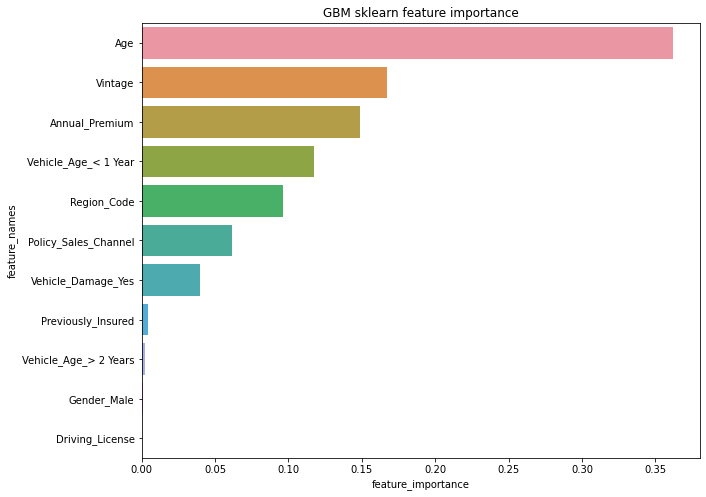

In [20]:
### Какие признаки оказались наиболее важны в model?

fi_df = pd.DataFrame({'feature_names': data.columns.drop('Response'),
                      'feature_importance': model.feature_importances_})

plt.figure(figsize=(10,8))
sns.barplot(x='feature_importance', y='feature_names', 
            data=fi_df.sort_values('feature_importance', ascending=False))
plt.title('GBM sklearn feature importance');

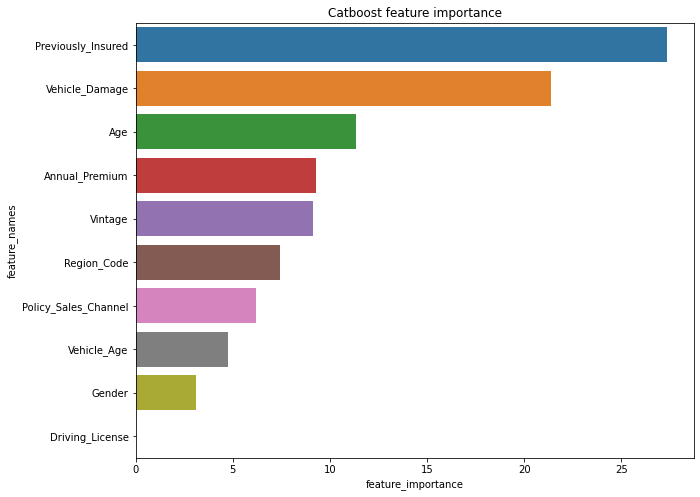

In [21]:
### А в катбусте?

fi_df = pd.DataFrame({'feature_names': data_copy.columns.drop('Response'),
                      'feature_importance': cboost.get_feature_importance()})

plt.figure(figsize=(10,8))
sns.barplot(x='feature_importance', y='feature_names', 
            data=fi_df.sort_values('feature_importance', ascending=False))
plt.title('Catboost feature importance');

**Задание 5.** Установите библиотеку `lightgbm`. На сегодняшний день это наиболее быстрый метод градиентного бустинга, при этом расходующий небольшое количество оперативной памяти. Достигает он этого за счет построения деревьев вглубь по листьям (leaf-wise), а не по уровням (level-wise), как другие методы, например XGBoost. 
Более понятно это на картинке:

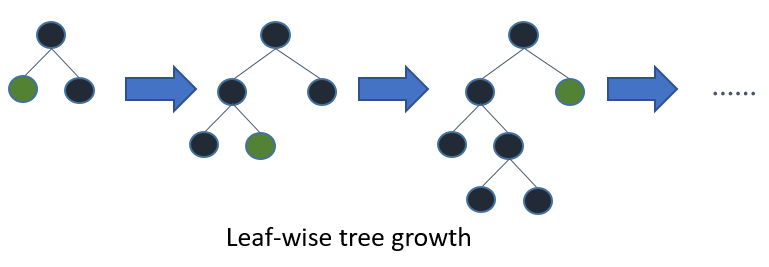

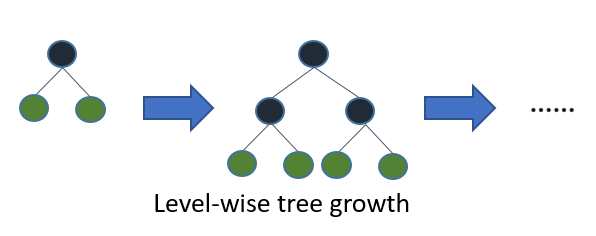

В то время, как XGBoost за раз разделяет вершины на целом уровне той же глубины, LightGBM разделяет одну вершину за раз. Отсюда прирост в скорости.

Обучите `LGBMClassifier` на изначальных данных и добейтесь максимального качества на тестовой выборке, перебрав параметры глубины деревьев, количества шагов, скорости обучения и т.д. по заданной сетке

In [22]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV

X = data.drop('Response', axis=1)
y = data['Response']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=0,
                                                    shuffle=True,
                                                    test_size=0.2)

In [23]:
%%time
params = {'n_estimators': [100, 500, 1000, 2000],
          'max_depth': [2, 3, 5, 100],
          'learning_rate': [0.1, 0.01, 0.001]}

grid = GridSearchCV(LGBMClassifier(), params)
grid.fit(X_train, y_train)

y_pred = grid.predict(X_test)
print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.8850    1.0000    0.9390      1770
           1     0.0000    0.0000    0.0000       230

    accuracy                         0.8850      2000
   macro avg     0.4425    0.5000    0.4695      2000
weighted avg     0.7832    0.8850    0.8310      2000

CPU times: user 22min 5s, sys: 11 s, total: 22min 16s
Wall time: 11min 12s


In [24]:
grid.best_estimator_

LGBMClassifier(learning_rate=0.01, max_depth=2)